# Table of contents

A general study of the data with some comments on outlier removal at the end.

* Part 1. [Getting the data](#Part1)
* Part 2. [Analyzing the data](#Part2)
    1. [Distribution of responses](#1)\
        1.1. [Informal comparison to Gaussian](#1.1)
    2. [Investigating variance in responses](#2)\
        2.1. [A visual study](#2.1)
        
        
        
    2. [Investigating bimodality](#2)\
        2.1 [Mode clusters...](#2.1)
        * effect on skew
    3. [Investigating variance of responses](#3)\
        3.1 [As a function of price volatility](#3.1)\
        3.2 [As a function of response time](#3.2)
    4. [Outlier analysis](#4)
        * center around median
    
 
* Part 3. [Conclusion](#Part3)

# Part 1: Getting the data <a class="anchor" id="Part1"></a>

In [679]:
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import quantumrandom
import random
import statsmodels.api as sm
import time
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
from tqdm.notebook import tqdm
# disable locks due to random deadlocks
tqdm.get_lock().locks = []
from web3 import Web3

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, DivergingNorm
COLORS_10 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
             '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
PALLETTE_10 = sns.set_palette(sns.color_palette(COLORS_10))
CHAINLINK_BLUE = '#2b5cdc'
CHAINLINK_BLUE_LIGHT = '#698CE5'
GREEN = '#69e584'
RED = '#dc2b5c'

from utils import (
    connect,
    generate_random_gaussians,
    load_oracle_responses,
    load_price_data,
    load_round_metrics
)

convert_unixtime = lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

The data gathering/loading functions are in `utils.py`. The functions grew to be quite long, so I migrated them over to a seperate file.

In [75]:
### oracle responses ###
df_responses = load_oracle_responses()

Latest round: 696
Last saved round: 689.
First block: 2020-04-29 18:02:37.
Round 690 USD-ETH price response: 2020-04-30 03:05:57.
Querying blockchain in chunks of 500 blocks. 6 chunks total.



Done.
Augmenting entries...
Adding timestamps...


Done.


In [4]:
df_responses

,price,answer_id,oracle,blockNumber,timestamp,date,price_float
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,9288039,1579122628,2020-01-15 21:10:28,166.313515
1,16670000000,1,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,9288039,1579122628,2020-01-15 21:10:28,166.700000
2,16582658130,1,0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A,9288039,1579122628,2020-01-15 21:10:28,165.826581
3,16643436950,1,0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B,9288039,1579122628,2020-01-15 21:10:28,166.434370
4,16614295610,1,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9288039,1579122628,2020-01-15 21:10:28,166.142956
...,...,...,...,...,...,...,...
14443,21744590914,689,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9971132,1588212039,2020-04-30 02:00:39,217.445909
14444,21741402764,689,0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3,9971132,1588212039,2020-04-30 02:00:39,217.414028
14445,21744590914,689,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9971131,1588212033,2020-04-30 02:00:33,217.445909
14446,21735648088,689,0x4565300C576431e5228e8aA32642D5739CF9247d,9971131,1588212033,2020-04-30 02:00:33,217.356481


# Part 2: Analyzing the data <a class="anchor" id="Part2"></a>

## 1. Distribution of price responses per heartbeat, for a recent 24 hour period <a class="anchor" id="1"></a>

1588214460.5839481 2020-04-30 02:41:00


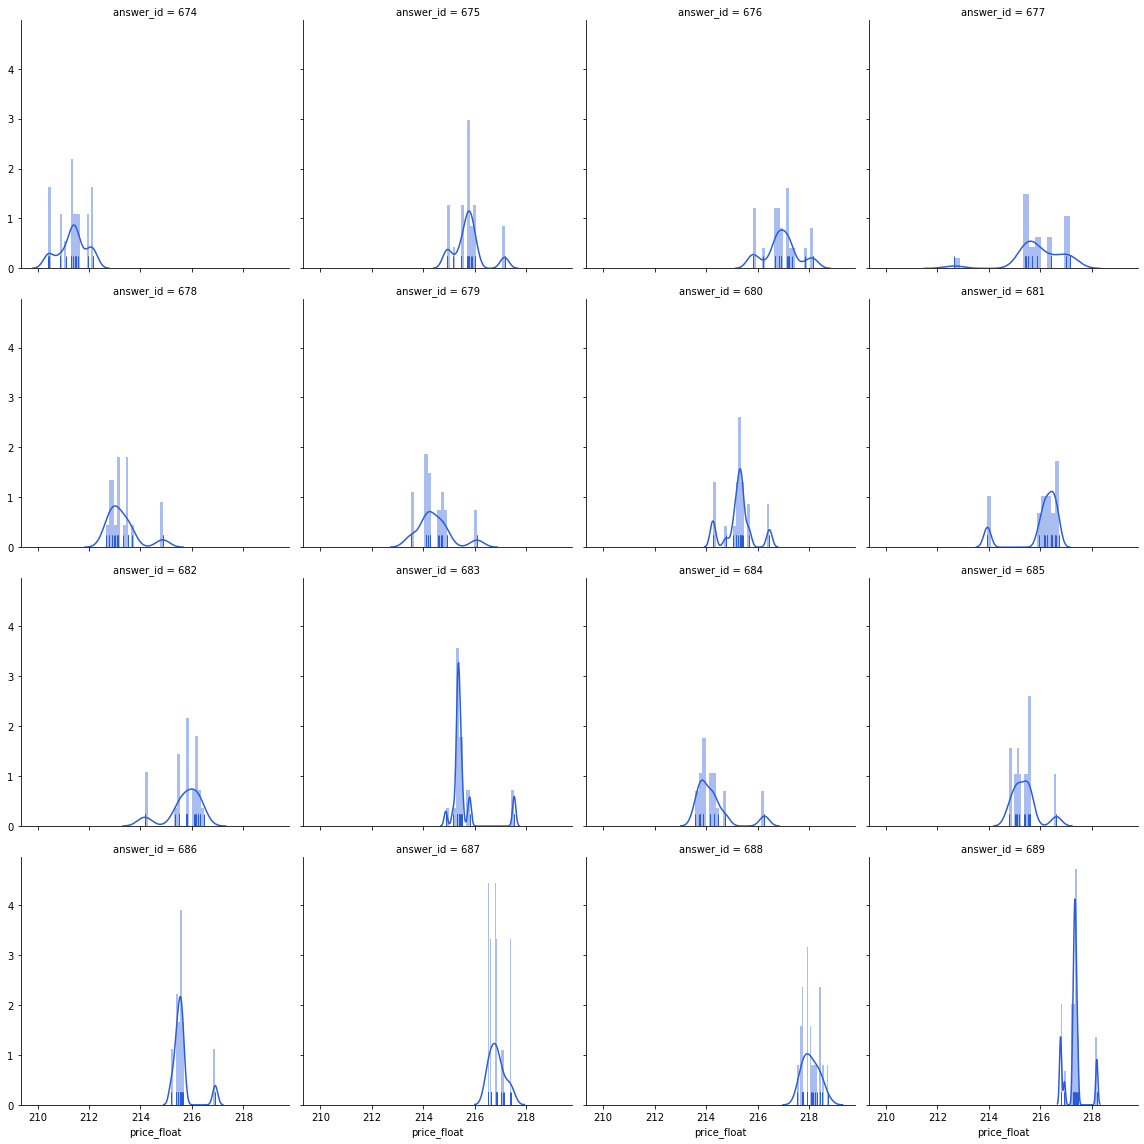

In [5]:
HOURS = 24

now = time.time()
print(now, convert_unixtime(now))
ts = now - timedelta(hours=HOURS).total_seconds()

# get last 16
lastn = 16
last_ans_id = max(df_responses[df_responses['timestamp']>=ts]['answer_id'])
df = df_responses[(df_responses['timestamp']>=ts) & (df_responses['answer_id']>last_ans_id-lastn)]

g = sns.FacetGrid(df, col="answer_id", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "price_float", rug=True, **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations & Thoughts:
* We can't assume, based on these distributions, that we are always dealing with *normally distributed data*.
    * This is perhaps due to the fact that we have only ~20 responses. Fitting distributions to small data sets is always a problem. But perhaps there's something else going on here ...
* Often we'll see what appears to be a **multi/bi-modal distribution**.
    * Could this be a result of prices being reported from different exchanges? i.e. some nodes aren't aggregating reponses, instead they report from one or two sources?
        * I could test this hypothesis if I knew where the oracles were getting their data from.
        * **Idea**: Oracles that aggregate their responses from multiple exchanges are likely to have responses closer to the mean/median. Would penalizing oracles with responses further from the center of the distribution incentivize them to gather information from many sources (which is what we want)?
        * **Idea**: a weighted average of prices from exchanges, where the weight is a function(\*) of *trading volume* is a better aggregation method for price oracles than simple average. This is because prices reported from various exchanges, weighted by the trading volume of those exchanges, is clearly closer to what we envision as the "true price". How do we enforce/incentivise this? Idea: somehow incentivise both accurate (close to mean/median) responses as well as responses representing a large trading volume?
    * Could this be due to oracles reporting at different times within a round?
        * **This will be tested in a bit.**

(\*) I say *function of* trading volume, because the weighting should be proportional to trading volume, but not exactly equal to it due to interactions such as liquidity (e.g. trading volume is directly correlated with liquidity which has an effect on price.

## 1.1 Informal comparison to Gaussian<a class="anchor" id="1.1"></a>
One might assume that the irregularities with the above distributions is simply an artifact arising from a small sample ($n=21$, see table below). We can informally test this by plotting samples ($n=21$) from a *true* normal distribution and then do an informal, visually comparison to our plots above.

In [9]:
df = df_responses[['answer_id']].groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(
        column="answer_id",
        aggfunc="count")
)
df.rename(columns={'count_col': 'n_oracles'}, inplace=True)

df.groupby(['n_oracles']).agg(
    count_col=pd.NamedAgg(
        column="n_oracles",
        aggfunc="count")
).rename(columns={'count_col': 'count'})

,count
n_oracles,
17,1
18,1
19,1
20,68
21,605
22,4
23,1
24,3
27,1


The large majority of the time we have 21 oracles responding.

In [10]:
N_SAMPLES = 16
df = generate_random_gaussians(21, N_SAMPLES)

Drawing 16 random samples (n=21) from Gaussian


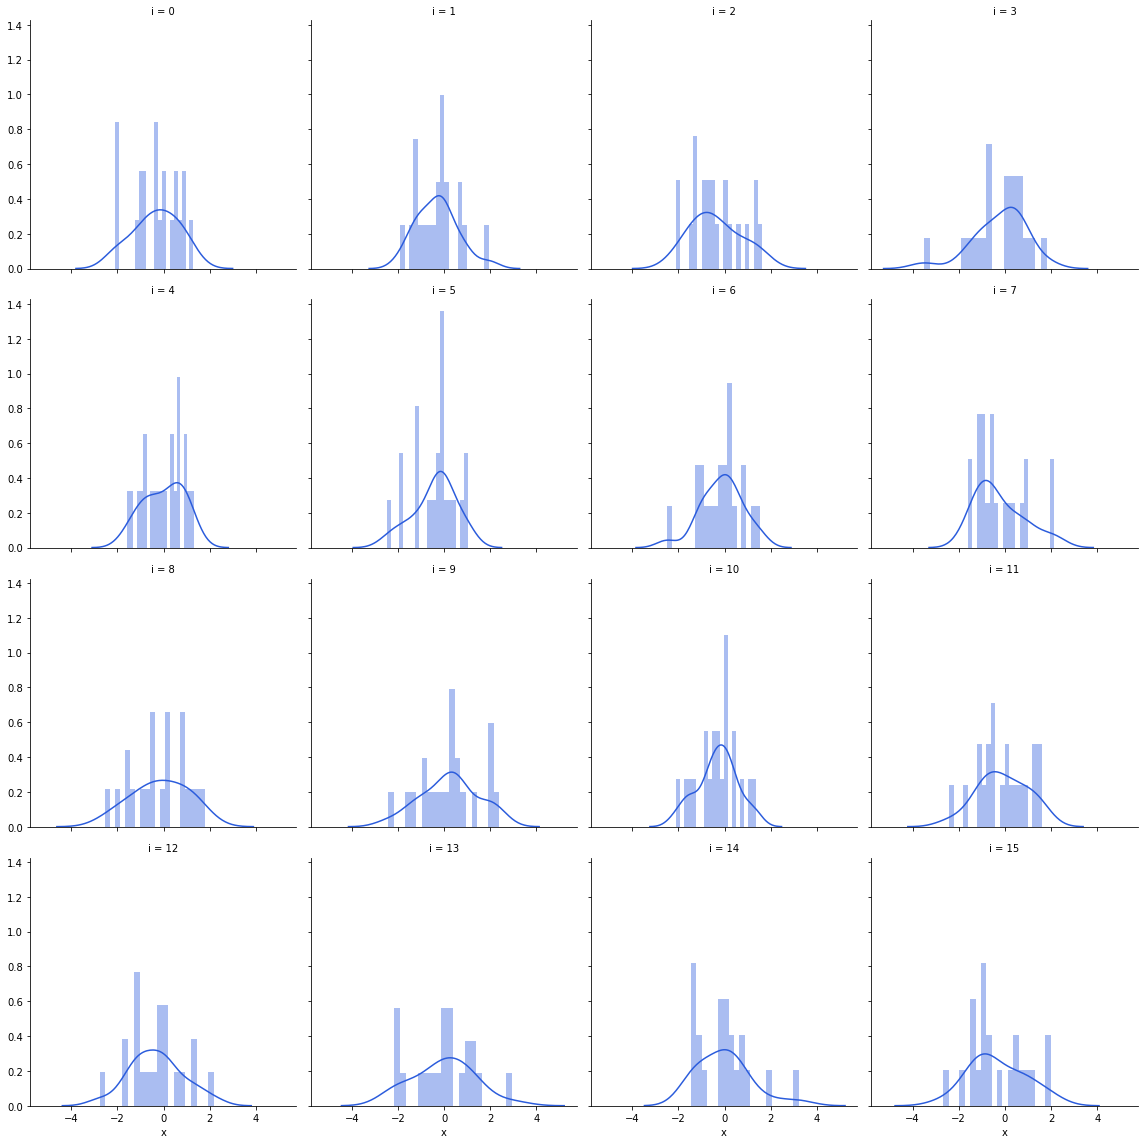

In [11]:
g = sns.FacetGrid(df, col="i", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "x", **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations:
- We note, visually, that bimodal \& multimodal distributions are not that common in samples ($n = 21$) generated from true normal distributions, suggesting that there is some underlying factor for why our oracle response distributions are multimodal.

### Further comparison to Gaussian: Violin plots

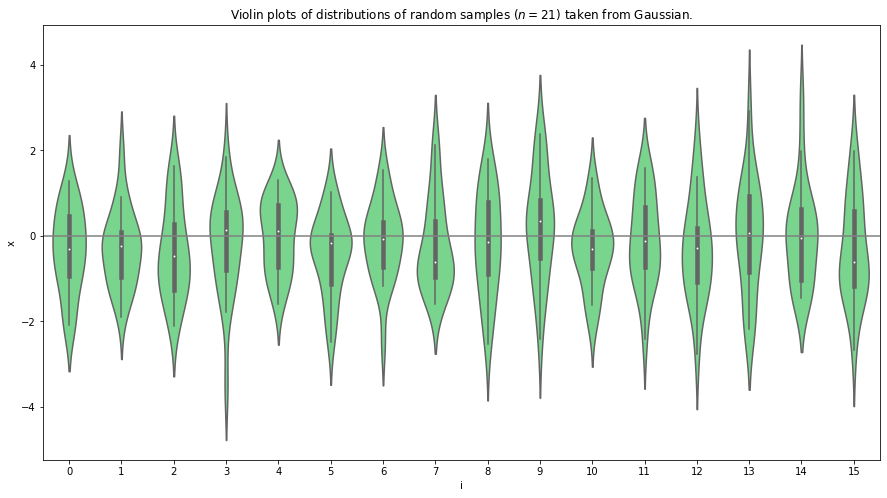

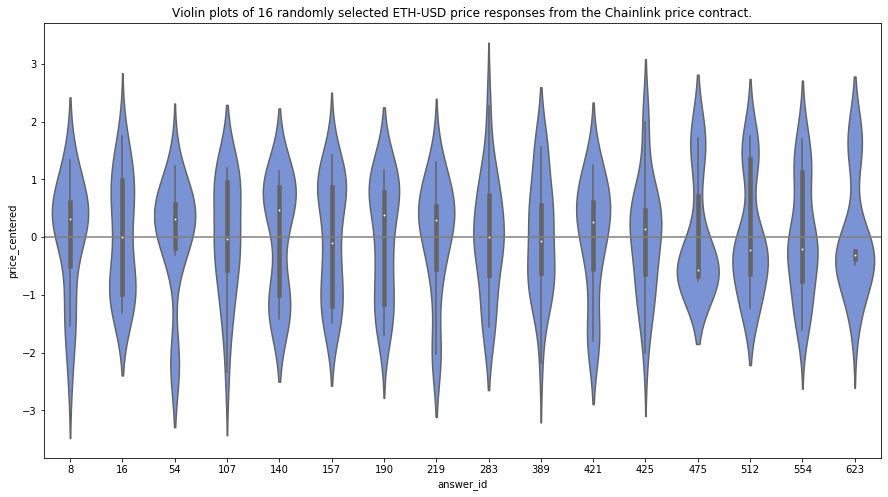

In [14]:
###
### violin plots for further visual study
###
f, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(
    ax=ax,
    x="i",
    y="x", 
    height=1, aspect=1,
    color=GREEN,
    data=df
).set_title('Violin plots of distributions of random samples ($n=21$) taken from Gaussian.')
ax = g.axes
ax.axhline(0, color='grey');

# center data -> mean=0, std=1
df_responses.loc[:,'price_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

# take a sample of previous rounds to simplify plotting
N_SAMPLES = 16
sample_ans_ids = df_responses['answer_id'].sample(N_SAMPLES)
df_sample = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]

_, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(
    ax=ax,
    x="answer_id",
    y="price_centered",
    height=1,
    aspect=1,
    color=CHAINLINK_BLUE_LIGHT,
    data=df_sample
).set_title('Violin plots of {} randomly selected ETH-USD price responses from the Chainlink price contract.'.format(N_SAMPLES))
ax = g.axes
ax.axhline(0, color='grey');

### Observations
* Note: the above distributions of price responses are centered (i.e. mean=0, std=1), so they hide any differences in variance between rounds. This is done so we can focus on the *shape* of the distributions.
* They look pretty okay, but let's focus on how they're different from samples drawn from normals.
     * They tend to be more skewed. See how the mode is rarely at the mean (compared to the true Gaussian distributions in green)? 
     * About half of the time, they tend to have a sperm-like appearance. Yes, that's a technical term. They typically have these long tails on one end.
* We will address potential reasons for why these response distributions are skewed and multimodal in proceeding sections where we look at the variance of the responses.

## 2. Exploring variance in responses<a class="anchor" id="2"></a>
We are interested in the variance of responses across rounds. We again compare to same-size samples drawn from a Gaussian.

## 2.1 A visual study<a class="anchor" id="2.1"></a>
We are interested in the variance of responses across rounds. We again compare to same-size samples drawn from a Gaussian.

In [20]:
NSAMPLES = 20
df_norm = generate_random_gaussians(21, NSAMPLES)

Drawing 20 random samples (n=21) from Gaussian


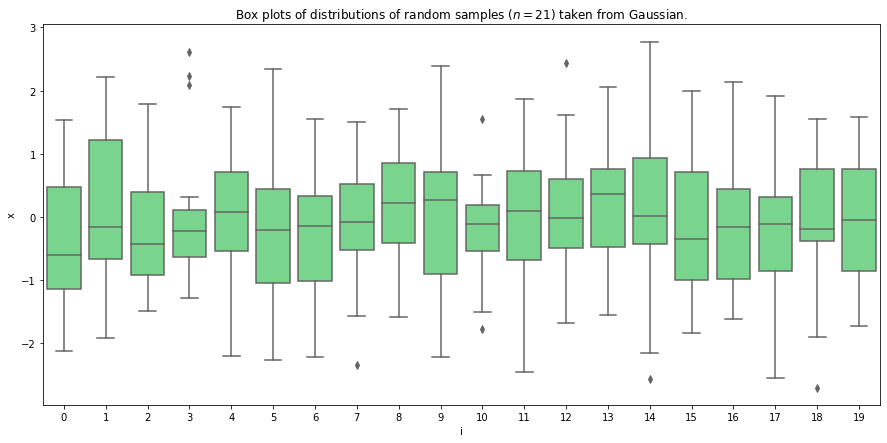

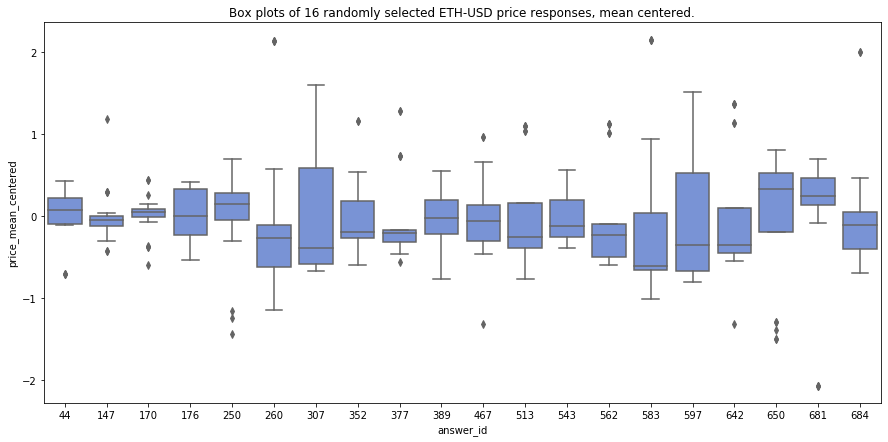

In [23]:
#
# plotting box plots for randomly selected rounds,
# and comparing them to Gaussians
#

### random samples from gaussian
_, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(
    ax=ax,
    x="i",
    y="x",
    color=GREEN,
    data=df_norm
).set_title('Box plots of distributions of random samples ($n=21$) taken from Gaussian.'.format(N_SAMPLES))

# mean center -> mean=0, keep variace the same
# this is done so we can more easily compare differences in variance
df_responses.loc[:,'price_mean_centered'] = df_responses.groupby('answer_id')['price_float'].transform(
    lambda x: x - x.mean()
) 
# randomly select `NSAMPLES` rounds
sample_ans_ids = df_responses['answer_id'].sample(NSAMPLES)
df = df_responses[df_responses['answer_id'].isin(sample_ans_ids)]

_, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(
    ax=ax,
    x="answer_id",
    y="price_mean_centered",
    color=CHAINLINK_BLUE_LIGHT,
    data=df
).set_title('Box plots of {} randomly selected ETH-USD price responses, mean centered.'.format(N_SAMPLES))

### Observations:
* First, note that the oracle responses are mean centered. This is done to emphasize the difference in variance between rounds.
* From an informal, visual inspection:
    * We have what appears might be a significant difference between variances in our oracle responses. Box plot ranges and IQRs appears to vary more than the gaussians (in green).
    * We again see some examples of a skew - the "line" in the box plot is often far from the center of the rectangle.
    * We see some clear outliers.

## 2.2 Exploring causes of variance
We analyze how the following factors affect the variance of oracle responses, for a given round:
* the length of a round
* variance of reporting times
* price volatility of asset (during the round)
How much do these factors influence the variability in responses.

### Getting the data

Price data.

In [24]:
### load price data gathered from the CryptoCompare API
df_prices = pd.read_csv('eth-usd_prices.csv', index_col=0)

In [25]:
df_prices

,time,high,low,open,volumefrom,volumeto,close
0,1587935700,197.01,196.59,197.01,579.44,113881.17,196.59
1,1587935760,196.71,196.56,196.65,403.38,79286.77,196.56
2,1587935820,196.69,196.58,196.61,276.62,54461.92,196.67
3,1587935880,196.72,196.65,196.67,136.90,26938.56,196.65
4,1587935940,196.69,196.61,196.65,805.18,158367.04,196.69
...,...,...,...,...,...,...,...
14396,1588037940,194.11,194.08,194.11,155.98,30273.02,194.10
14397,1588038000,194.06,193.98,194.10,438.46,85085.60,194.06
14398,1588038060,193.97,193.89,194.06,821.31,159308.54,193.97
14399,1588038120,193.79,193.71,193.97,1305.36,252862.42,193.71


Round metrics.

In [ ]:
### load various metrics pertaining to a rounds
df_rounds = load_round_metrics(df_prices, df_responses)
df_rounds

In [584]:
# removing clear outliers
# - the last two round haven't ended (`ts_end`=0) so we remove them
# - also, first two rounds are exeedingly long (probably some test runs)
df_rounds = df_rounds[(0 <= df_rounds['round_length']) & (df_rounds['round_length'] <= 6000)]
df_rounds = df_rounds[(0 <= df_rounds['response_std_price']) & (df_rounds['response_std_price'] <= 10)]
df_rounds = df_rounds[(0 <= df_rounds['response_std_ts']) & (df_rounds['response_std_ts'] <= 150)]
df_rounds
# TODO: don't remove entire rounds, remove responses with really long response times

,block_number,ts_start,ts_end,round_length,response_std_ts,response_std_price,volatility
round_id,,,,,,,
4,9837987,1586434798,1586438780,3982,33.924145,0.215972,NaN
5,9838260,1586438625,1586441008,2383,24.395647,0.179356,NaN
7,9838903,1586447154,1586448061,907,5.353682,0.314477,NaN
9,9839510,1586455205,1586458742,3537,16.867975,0.401519,NaN
10,9839786,1586458652,1586462511,3859,11.568430,0.367883,NaN
...,...,...,...,...,...,...,...
692,9971550,1588217816,1588218560,744,48.204228,0.766843,NaN
693,9971587,1588218405,1588219505,1100,107.772202,1.098395,NaN
694,9971639,1588219252,1588219639,387,66.322157,1.246002,NaN


### 2.2.1 Price volatility, round duration, and dispersion of response times

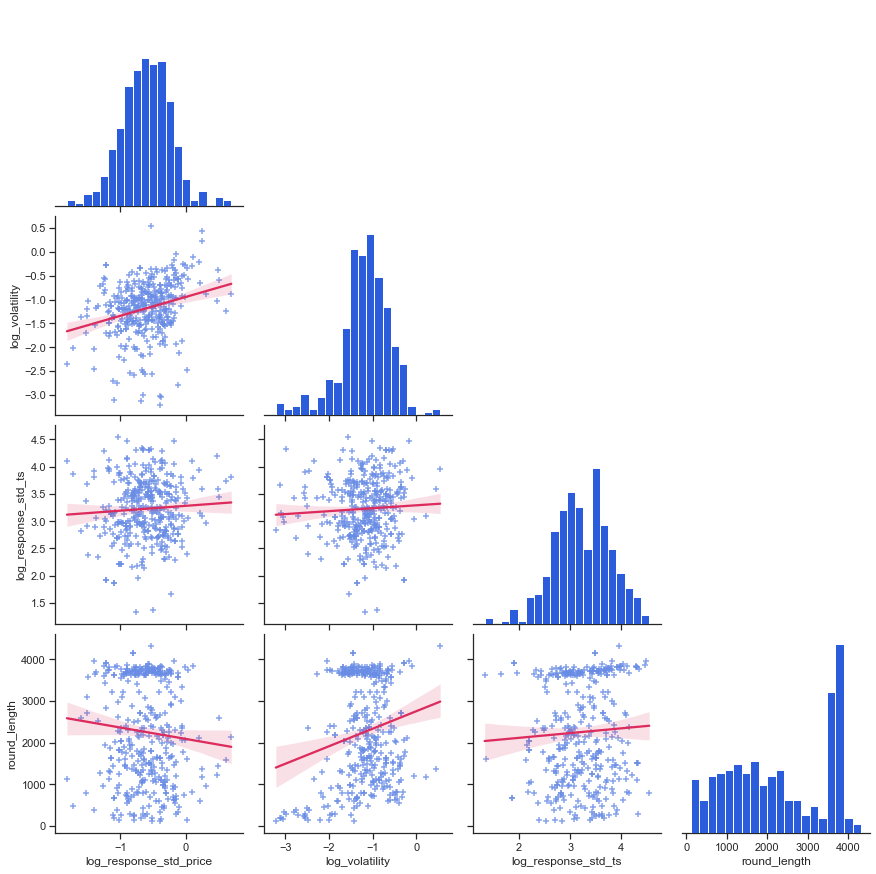

In [623]:
'''
adding some data:
- we don't want timestamps to be the only measure of response times
- timestamps are approximated from the block number where response is located
- want to also include "block distance"
'''
df = pd.DataFrame()
df['log_response_std_price'] = np.log(df_rounds['response_std_price'])
df_rounds['log_volatility'] = np.log(df_rounds['volatility'])
df['log_volatility'] = df_rounds['log_volatility']
df['log_response_std_ts'] = np.log(df_rounds['response_std_ts'])
df['round_length'] = df_rounds['round_length']

# a few weird outliers
df = df[df['log_volatility'] > -4]

# add log(volatility)
#df['log_volatility'] = np.log(df_rounds['volatility'])
#df['log_response_std_ts'] = np.log(df_rounds['response_std_ts'])
df = df.dropna()

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    df, diag_kind="hist", kind="reg", markers="+", height=3,
    palette='Blues',
    corner=True,
    diag_kws={'bins':20, 'color': CHAINLINK_BLUE},
    plot_kws={'color': CHAINLINK_BLUE_LIGHT, 'line_kws':{'color':RED}}
)

### Observations \& Comments
- we have multicollinearity
    - That's fine. These factors are clearly correlated (e.g. longer rounds are expected to have more price volatility). We are interested in explaining the variance in price responses *as a whole* not necessarily how much individual factors affect price (the only case in which multicollinearity would matter).
- all of our factors appear correlated to some degree
    - strongest correlation between price volatility and the standard deviation in prices resported by oracles for a given round
- round length not spread out enough, def not normally distributed, also produces weird results

### 2.2.2 Multivariate regression

In [603]:
X = df[['log_volatility', 'log_response_std_ts']]
X = sm.add_constant(X)
y = df['log_response_std_price']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_response_std_price   R-squared:                       0.073
Model:                                OLS   Adj. R-squared:                  0.068
Method:                     Least Squares   F-statistic:                     14.43
Date:                    Thu, 30 Apr 2020   Prob (F-statistic):           9.25e-07
Time:                            23:44:33   Log-Likelihood:                -157.78
No. Observations:                     372   AIC:                             321.6
Df Residuals:                         369   BIC:                             333.3
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5018      0.123     -4.079      0.000      -0.744      -0.260
log_volatility          0.1763      0.034      5.230      0.000       0.110       0.243
log_response_std_ts     0.0327      0.035      0.937      0.350      -0.036       0.101
==============================================================================
Omnibus:                        2.624   Durbin-Watson:                   0.912
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                2.802
Skew:                          -0.003   Prob(JB):                        0.246
Kurtosis:                       3.425   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [780]:
# measuring correlation between price volatility and price response variance
# we can't conclude our variables of interest are normally distributed, so we use non-parametric Spearman correlation
df = df_rounds[['volatility', 'response_std_price', 'round_length']]
df = df.dropna()
print('correlation between volatility and std of responses')
res = stats.spearmanr(df['volatility'], df['response_std_price'])
print(res)
print('correlation between variability in response times and std of responses')
res = stats.spearmanr(df_rounds['response_std_ts'], df_rounds['response_std_price'])
print(res)

correlation between volatility and std of responses
SpearmanrResult(correlation=0.26790184606320094, pvalue=1.4963655248481164e-07)
correlation between variability in response times and std of responses
SpearmanrResult(correlation=0.09117154031786744, pvalue=0.024567645538013407)


**Summary**: strong correlation between price volatility and dispersion of responses (`correlation coefficient = 0.268`, `p-value < 1e-6`) and a weak correlation between dispersion of response *times* and dispersion of *responses* (`correlation coefficient = 0.091`, `p-value < 0.05`)

### 2.2.3 How much do individual oracles have an effect on variability?
The only other information that I felt could explain some of the variability in responses, is the oracles themselves. Do some oracles provide poorer responses (in this case, responses that are "more distant" than other reponses in a round)? We test this quite crudely using individual oracles as dunny variables, but I don't this an ideal method, as I will explain below.

In [641]:
df = pd.concat([df_responses['answer_id'], pd.get_dummies(df_responses['oracle'], prefix='oracle')], axis=1)
df = df.groupby('answer_id').sum()
df = df_rounds.join(df)

oracles = [c_ for c_ in df if c_.startswith('oracle')]
# weird result with this oracle ... need to investigate
oracles.remove('oracle_0x78E76126719715Eddf107cD70f3A31dddF31f85A')

subset = df[[*oracles]]

model = sm.OLS(endog=df['response_std_price'], exog=subset, missing='drop')
results = model.fit()
results.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     response_std_price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5338
Date:                Fri, 01 May 2020   Prob (F-statistic):              0.904
Time:                        00:23:40   Log-Likelihood:                -126.48
No. Observations:                 608   AIC:                             281.0
Df Residuals:                     594   BIC:                             342.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|       [0.05       0.95]
---------------------------------------------------------------------------------------------------------------------
oracle_0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484     0.0377      0.100      0.379      0.705      -0.126       0.202
oracle_0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613    -0.5628      0.382     -1.474      0.141      -1.192       0.066
oracle_0x240BaE5A27233Fd3aC5440B5a598467725F7D1cd     0.2478      0.344      0.720      0.472      -0.319       0.815
oracle_0x24A718307Ce9B2420962fd5043fb876e17430934     0.0517      0.178      0.290      0.772      -0.242       0.346
oracle_0x2Ed7E9fCd3c0568dC6167F0b8aEe06A02CD9ebd8     0.0517      0.178      0.290      0.772      -0.242       0.346
oracle_0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A     0.2978      0.307      0.970      0.333      -0.208       0.804
oracle_0x4565300C576431e5228e8aA32642D5739CF9247d     0.0377      0.100      0.379      0.705      -0.126       0.202
oracle_0x58c69aFF4Df980357034eA98AaD35bbF78cBD849     0.2978      0.307      0.970      0.333      -0.208       0.804
oracle_0x64FE692be4b42F4Ac9d4617aB824E088350C11C2    -0.0353      0.111     -0.319      0.750      -0.218       0.147
oracle_0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5    -0.1477      0.473     -0.312      0.755      -0.927       0.631
oracle_0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B    -0.0649      0.175     -0.372      0.710      -0.352       0.223
oracle_0x7e94A8A23687D8C7058Ba5625dB2Ce358bCbd244     0.1719      0.189      0.908      0.364      -0.140       0.484
oracle_0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1     0.1178      0.111      1.061      0.289      -0.065       0.301
oracle_0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B    -0.1261      0.253     -0.499      0.618      -0.542       0.290
oracle_0x89f70fA9F439dbd0A1BC22a09BEFc56adA04d9b4     0.0377      0.100      0.379      0.705      -0.126       0.202
oracle_0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3     0.0532      0.042      1.280      0.201      -0.015       0.122
oracle_0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a    -0.1273      0.302     -0.422      0.673      -0.624       0.370
oracle_0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb     0.2833      0.486      0.583      0.560      -0.517       1.083
oracle_0xB92ec7D213a28e21b426D79EDe3c9BBcf6917c09     0.0517      0.178      0.290      0.772      -0.242       0.346
oracle_0xF3b450002C7Bc300eA03c9463d8E8BA7f821b7c6    -0.0353      0.111     -0.319      0.750      -0.218       0.147
oracle_0xF5a3d443FccD7eE567000E43B23b0e98d96445CE    -0.0181      0.610     -0.030      0.976      -1.023       0.987
==============================================================================
Omnibus:                      202.740   Durbin-Watson:                   0.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              650.500
Skew:         

Note: not a perfect test. It seems like most of these oracles respond most of the time, so it's hard to judge their effect. None of the confidence intervals are fully in the positive (i.e. we're confident that those oracles are correlated with an increase in price variability per round).

### Conclusions

The only thing we can *confidently* state regarding causes of response variability per round is that price volatility has a definite and strong effect: Spearman correlation = 0.268; p-value < 1e-06. Price response times also show a significant effect, albeit milder.

A very interesting point is that it isn't clear what the causal mechanism is precisely for volatility -> response dispersion. Consider the following:

* If ETH-USD prices are volatile during the round, there are more opportunities for oracles to respond with different answers, simply because the variable they are reporting takes on many values within the period of interest.
* ETH-USD volatility is a known cause of high gas prices in the Ethereum network. This might cause rounds to take longer to complete, thereby increasing the amount of time oracles have to report, increasing the variability of responses.
    * I should really do this analysis with another price pair to decouple these two causes, but, then again, any volatile price pair is probably also correlated with volatility in ETH-USD ..

**Note**: It's very likely that price response times *are* a stronger cause of variability than we were able to detect with the tests above. We are unable to precisely capture this information because we don't know the exact time a price was reported by an oracle. The timestamp of a response is calculated from it's blocknumber. And a block can take anywhere from 15 seconds to 30 minutes to mine (see: https://ethgasstation.info/).

## 2.3 Relationship between response time and accuracy of response
Note that we measure "accuracy" by how close the response is to the median. This isn't an ideal measure of accuracy as will be explained in the discussion section at the end. Assume it's a good measure for now.

In [765]:
def ts_percentile(row):
    rnd = int(row['answer_id'])
    return (row['timestamp'] - df_rounds.loc[rnd]['ts_start']) / df_rounds.loc[rnd]['round_length']

df = df_responses

# compute ranks
df['ts_rank_pct'] = df.groupby(['answer_id']).agg(
    count_col=pd.NamedAgg(column='timestamp', aggfunc="rank")
)
df.rename(columns={'count_col': 'ts_rank_pct'}, inplace=True)

# only inlude rounds where there is a good seperation of timestamps
df = df.groupby('answer_id').filter(lambda g: (g.ts_rank_pct > 20).any())

In [766]:
def dist_from_median(row):
    df = df_responses
    df = df[df['answer_id'] == row['answer_id']]
    med = np.median(df['price_float'])
    return med - row['price_float']

df['dist_from_median'] = df.apply(lambda row: dist_from_median(row), axis=1)

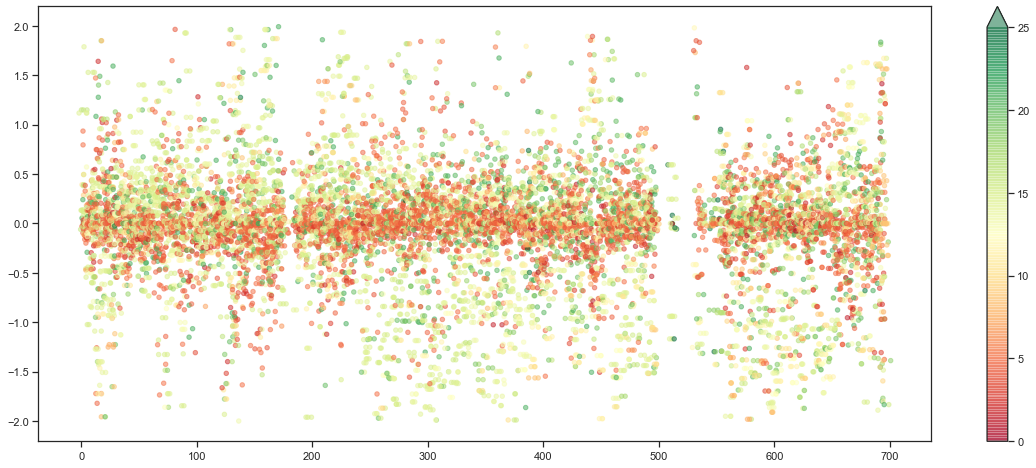

In [775]:
# I'll be plotting this a few times,
# so might as well make a function
def plot(df, cmap='RdYlGn', figsize=(20, 8)):
    plt.figure(figsize=figsize)
    def __add_jitter(x):
        # for visual ease
        std = .01 * x.std()
        return x + np.random.randn(len(x)) * std
    plt.scatter(
        add_jitter(df.answer_id),
        df.dist_from_median,
        alpha =0.5,
        c = df.ts_rank_pct,
        cmap=cmap,
        s=20
    )   
    #cbar = plt.colorbar()
    plt.colorbar(extend='max')
    plt.clim(0, 25);

plot(df)

Removing outlier-ish data (points more than \$2) from median.

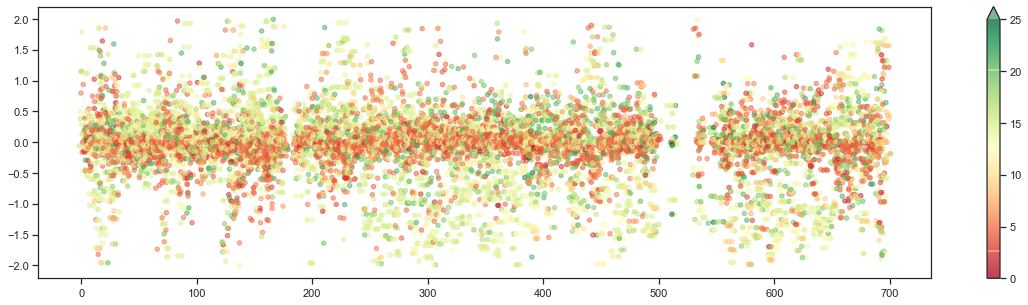

In [776]:
df = df[(-2 <= df.dist_from_median) & (df.dist_from_median <= 2)]
plot(df, figsize=(20, 5))

And just to confirm this isn't some optical illusion with colors :), we reverse the colorbar:

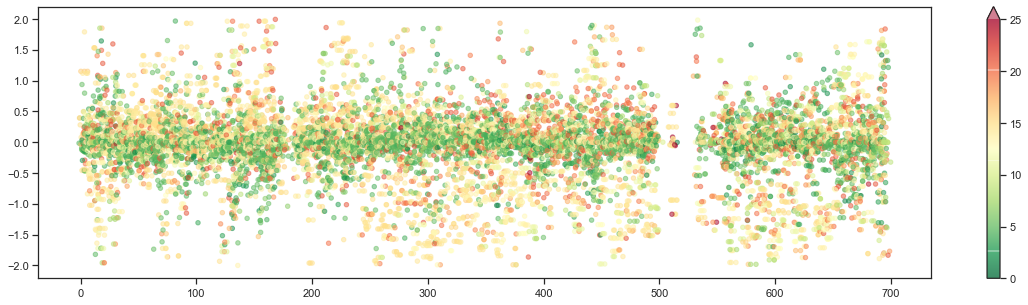

In [777]:
plot(df, cmap='RdYlGn_r', figsize=(20, 5))

And to add some formality with a statistical test:

In [778]:
stats.spearmanr(df['ts_rank_pct'], df['dist_from_median'])

SpearmanrResult(correlation=0.04071939476603056, pvalue=5.332399784687625e-06)

We have a significant and positive (albeit weak) correlation between response time (measured by percent rank) and distance from median.

### Observations \& Conclusions
Recall: the y-axis is the distance of the response from the median (in a given round). In this context, it represents the difference in \$ (USD) between an oracle response and the median response. It measures how "off" the oracle is: closer to 0 is good, further is bad. The x-axis it the round number/ answer ID. Importantly, the color represents the percentile rank of the response's timestamp; in simple terms: smaller numbers (corresponding to darker green above) are responses that occured first and larger numbers (corresponding to red above) are responses that occured later.

We conclude:
* Oracles that respond earlier tend to be closer to the median.
* Since we calculate distance from *median*, not *mean*, we can conclude that the median response occurs near the start of the round, which directly implies that most responses happen near the start of the round.
    * This further implies that nodes that respond later are more likely to be outliers. This, again, is probably an artifact of price volatility; i.e. the longer you wait to respond, the more likely the price is to change.
            
**Note**: the timestamp rank is extremely crude -- timestamps are approximated from block numbers and many responses are mined on the same block, thus many responses share the same rank. This is why the maximum rank percentage per round/ answer ID tends to be around 20-30 and not 100.

# Rough Work

# Outlier detection

Notes: IQR is great because we can assume at least 50% of nodes are honest

In [455]:
#TODO: undo
df_responses = df_responses[df_responses['answer_id'] > 2]

In [388]:
df_responses['price'] = df_responses['price_float']
df = df_responses[['answer_id', 'price_float']]
Q1 = df.groupby('answer_id').quantile(0.25)
Q3 = df.groupby('answer_id').quantile(0.75)

In [472]:
#
# compute % change in variance with/without given point
# reason: we want to capture how much one single point contributes to the deviance of a sample
#

#added variation in response time vs added variation in price
# - percentage change in variance
def pct_change_sigma(row, col):
    df = df_responses
    df = df[df['answer_id'] == row['answer_id']]
    #print(row.name)
    #print(df)
    df_ = df.drop(row.name) # sample with point removed
    std = df[col].std()
    std_ = df_[col].std()
    # We add a small amount to our demoninator because
    # there is the chance that std is zero; e.g. since
    # timestamps are quite crude (calculated from block number),
    # there is the chance that, in a given round, all responses
    # have the same timestamp.
    # 0.001 shouldn't be more than 1% of std
    return 100 * (std - std_) / (std_ + 0.001)

df_responses['pct_change_price'] = df_responses.apply(lambda row: pct_change_sigma(row, 'price_float'), axis=1)
df_responses['pct_change_ts'] = df_responses.apply(lambda row: pct_change_sigma(row, 'timestamp'), axis=1)


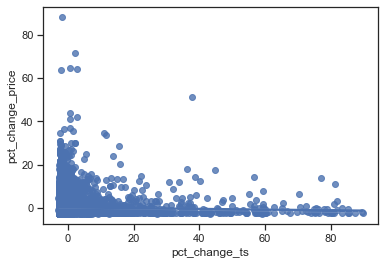

In [455]:
df = df_responses[['pct_change_ts', 'pct_change_price']]
df = df[df['pct_change_ts'].abs() < 90]
df = df[df['pct_change_price'].abs() < 90]

#df = df.applymap(lambda x: np.log(3 + x))

# 
# TODO: explain, esp. explain why better than log transform in this context
# https://www.jstor.org/stable/2288929?seq=1
# defined on all real numbers (our % changes can be positive or negative) unlike log
# other transforms could be used; I'd say good enough for our purposes right now.
sns.regplot(x="pct_change_ts", y="pct_change_price", data=df)

# Conclusion
- What is the application? Daily average versus high-frequency trading? Is HFT even possilble as a blockchain application? Is that even a good thing or a bad thing? I digress ....
- Moonshot ideas: somehow incentivise oracles to respond at the same time
- oracles that respond later tend to be outliers, or closest to "outlier territory"
- all depends on context (high-frequency, vs average per day). There's a lot of subtelty here.